In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd -q ..

In [3]:
import lcpfn 
import torch 
import torch as th
import json
import os
import numpy as np
from matplotlib import pyplot as plt

In [13]:
def readDatasetJson(path):
    f = open(path)

    dataset = json.load(f)
    # print(len(dataset))
    
    x = []
    y = []

    for v in dataset.values():
        x.append(v[0])
        y.append(v[1])
        
    x_true = th.Tensor(x)
    y_true = th.Tensor(y)
    
    return x_true, y_true

def find_file(root_dir, target_filename):
    for root, dirs, files in os.walk(root_dir):
        if target_filename in files:
            return os.path.join(root, target_filename)
    
    # If the loop completes without returning, the file was not found
    return None

def find_data():
    return find_file(os.getcwd(), 'data.json')

def get_data():
    return readDatasetJson(find_data())

def get_test_batch(
    batch_size,
    num_features = 1,
    seq_len = 26,
    device = "cpu",
):
    assert num_features == 1

    x_data, y_data = get_data()
   
    x_data = x_data[3302-batch_size:, :]
    y_data = y_data[3302-batch_size:, :]
    
    y_data_noisy = y_data.clone()
    
    x_data = x_data.view((num_features, batch_size, seq_len)).transpose(2, 0).to(device)
    y_data = y_data.transpose(1, 0).to(device)
    y_data_noisy = y_data.clone()

    return x_data, y_data, y_data_noisy

def get_batch(
    batch_size,
    seq_len,
    num_features,
    device="cpu",
    noisy_target=True,
    **_,
):
    assert num_features == 1

    x_data, y_data = get_data()
    print(x_data.shape)
    x_data = x_data[:batch_size, :]
    y_data = y_data[:batch_size, :]

    y_data_noisy = y_data.clone()

    x_data = x_data.view((num_features, batch_size, seq_len)).transpose(2, 0).to(device)
    y_data = y_data.transpose(1, 0).to(device)
    y_data_noisy = y_data.clone()

    return x_data, y_data, y_data_noisy

## Load trained LC-PFN model

In [5]:
result = lcpfn.train_lcpfn(get_batch_func=get_batch, 
                         seq_len=26,
                         emsize=256,
                         nlayers=12,
                         lr=0.001,
                         batch_size=1651,
                         epochs=0)

result[2].load_state_dict(th.load("C:\\Users\\mjaic\\OneDrive\\Desktop\\Delft\\Year 1\\Q3\\Deep Learning\\deep-learning-project\\notebooks\\model_1651.pth"))
model = result[2]

model = lcpfn.LCPFN(model)

Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 1651, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x0000028616AE1940>, 'seq_len_maximum': 26, 'device': 'cpu:0', 'num_features': 1, 'hyperparameters': {}}, 'num_features': 1}
torch.Size([3302, 26])
Style definition: None
Using a Transformer with 6.46 M parameters


## Generate a learning curve from the prior

(0.0, 1.0)

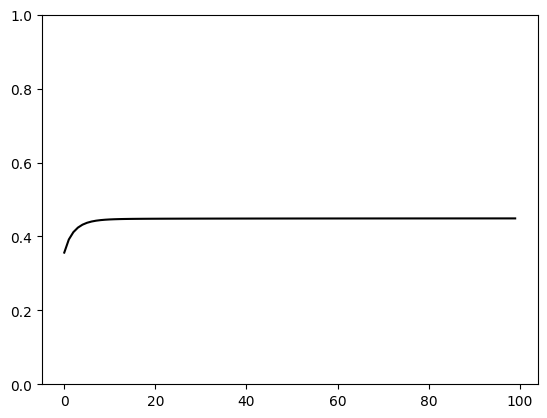

In [31]:
prior = lcpfn.sample_from_prior(np.random)
curve, _ = prior()
plt.plot(curve, "black")
plt.ylim(0, 1)

## Extrapolate the learning curve with a cutoff of 10% 

In [37]:
# construct 

# x = torch.arange(1, 101).unsqueeze(1)
# y = torch.from_numpy(curve).float().unsqueeze(1)
# cutoff = 10

x, y, _ = get_test_batch(1)
x = x.squeeze(dim=-1)
cutoff = 13


tensor([[0.9985],
        [0.9973],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [0.9998],
        [0.9996],
        [0.9996],
        [0.9995],
        [0.9994],
        [0.9992],
        [0.9991],
        [0.9989],
        [0.9987],
        [0.9984],
        [0.9982],
        [0.9978],
        [0.9974],
        [0.9971]])


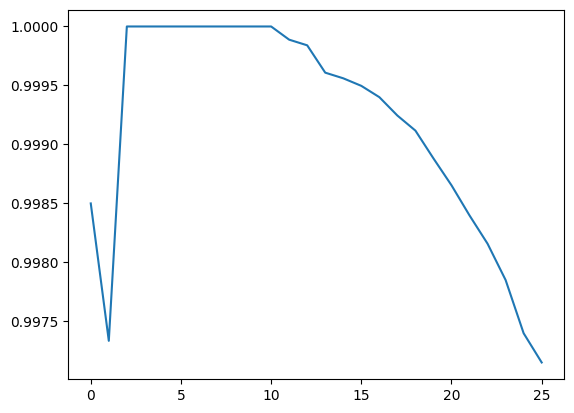

In [47]:
#predictions = model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

predictions = model.forward(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:])
predictions = predictions.squeeze(-1)


IndexError: index 1 is out of bounds for dimension 1 with size 1

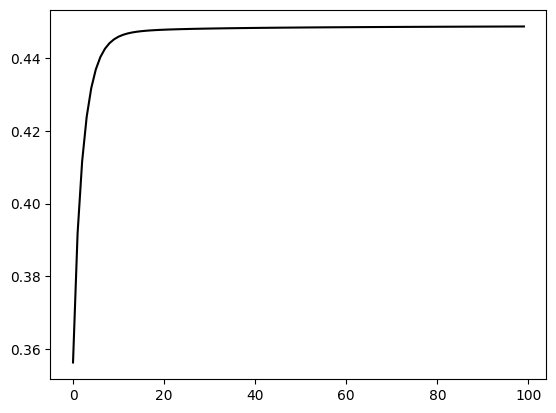

In [45]:
# plot data
plt.plot(curve, "black", label="target")

# plot extrapolation
plt.plot(x[cutoff:], predictions[:, 1], "blue", label="Extrapolation by PFN")
plt.fill_between(
        x[cutoff:].flatten(), predictions[:, 0], predictions[:, 2], color="blue", alpha=0.2, label="CI of 90%"
)

# plot cutoff
plt.vlines(cutoff, 0, 1, linewidth=0.5, color="k", label="cutoff")
plt.ylim(0, 1)
plt.legend(loc="lower right")